In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon, Rectangle
from shapely.geometry import Polygon, MultiPolygon, shape, mapping
import fiona
# If below doesn't work, run in cmd: conda install -c conda-forge basemap 
from mpl_toolkits.basemap import Basemap
from descartes import PolygonPatch
import os
import seaborn as sns

### Relevant 2017 variables

**Housing Record**

Dep. Var 
- FS (Yearly food stamp/SNAP recipiency)

Ind. Var
- PUMA
- WGTP (household weight) 
- ADJINC (adjustment factor for income)
- HINCP (mean household income)
- NP (Number of persons in this household)
- HHT (Household/family type) (Note: Could determine proportion of partnered/unpartnered households with children by crosstabbing with transformed HUPAC)
- FES (Family type and employment status)
- HHL (primary language spoken)
- HUPAC (presence and age of children) (Note: need variable transformation to a binary and drop NA's depending on whether the age is important) 

**Person Record**

Ind. Var 
- PUMA
- PWGTP (person's weight) 
- ADJINC (adjustment factor for income) 
- WAGP (wages/salary income the past 12 mo.) 
- AGE 
- ENG (ability to speak English) 
- MIL (military service) 
- SEX 
- HICOV (health insurance coverage) 
- NATIVITY 
- RAC1P (race)
- ESP (employment status of parents)
- JWTR (means of transportation to work)
- OCCP (occupation) (Note: Top 5-10 industries of employment, for example food industry, construction, etc. VS. job within industry. It would be handy to have the proportion in the industries as well)

### Merge Person to Household datasets

Connecting HH and Person records (scroll to bottom "Merging Person and Housing Unit Files": 
https://www.census.gov/programs-surveys/acs/technical-documentation/pums/filestructure.html

HH Record DD: 
RT = Record Type 
SERIALNO = Housing unit/GQ person serial number 

Person Record DD: 
RT = Record Type
SERIALNO = Housing Unit/GC person serial number
SPORDER = Person number (1-20)

Downloaded person data from: 
https://www2.census.gov/programs-surveys/acs/data/pums/2016/1-Year/

In [5]:
# Load household-level data
acs_17_hh = pd.read_csv('Data/psam_h53.csv')

In [6]:
len(acs_17_hh)

34091

In [7]:
# Number of housing units in Washington state
acs_17_hh.WGTP.sum()

3103263

In [8]:
acs_17_hh.head()

,RT,SERIALNO,DIVISION,PUMA,REGION,ST,ADJHSG,ADJINC,WGTP,NP,...,WGTP71,WGTP72,WGTP73,WGTP74,WGTP75,WGTP76,WGTP77,WGTP78,WGTP79,WGTP80
0,H,2017000000027,9,11603,4,53,1000000,1011189,126,1,...,36,104,125,121,114,216,39,121,101,244
1,H,2017000000082,9,11200,4,53,1000000,1011189,127,4,...,143,40,126,33,183,129,38,39,113,117
2,H,2017000000099,9,11702,4,53,1000000,1011189,47,2,...,12,54,43,13,67,47,74,59,49,55
3,H,2017000000103,9,10100,4,53,1000000,1011189,52,3,...,63,15,11,49,48,19,77,50,88,58
4,H,2017000000108,9,11603,4,53,1000000,1011189,111,2,...,194,32,108,168,36,29,101,119,176,108


In [9]:
# Load person-level data
acs_17_p = pd.read_csv('Data/psam_p53.csv')

In [10]:
acs_17_p.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2017000000027,9,1,11603,4,53,1011189,126,47,...,36,104,125,120,114,216,39,122,101,244
1,P,2017000000082,9,1,11200,4,53,1011189,126,35,...,144,40,126,34,182,129,38,39,113,117
2,P,2017000000082,9,2,11200,4,53,1011189,99,38,...,94,31,90,31,135,91,29,29,92,100
3,P,2017000000082,9,3,11200,4,53,1011189,120,14,...,124,33,105,39,190,116,38,31,113,105
4,P,2017000000082,9,4,11200,4,53,1011189,144,6,...,165,49,138,36,217,127,35,39,144,120


In [11]:
acs_17_p = acs_17_p[acs_17_p.SPORDER==1]

Note everything we conclude at the person level is about household HEADS at this point on. 

In [12]:
acs_17_hh.sort_values(by="SERIALNO",inplace=True)

In [13]:
acs_17_p.sort_values(by="SERIALNO",inplace=True)

In [14]:
pumas_hh_merge = acs_17_hh.merge(acs_17_p,how="left",on=["SERIALNO", "PUMA", "ST"])

In [15]:
pumas_hh_merge.head()

,RT_x,SERIALNO,DIVISION_x,PUMA,REGION_x,ST,ADJHSG,ADJINC_x,WGTP,NP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,H,2017000000027,9,11603,4,53,1000000,1011189,126,1,...,36.0,104.0,125.0,120.0,114.0,216.0,39.0,122.0,101.0,244.0
1,H,2017000000082,9,11200,4,53,1000000,1011189,127,4,...,144.0,40.0,126.0,34.0,182.0,129.0,38.0,39.0,113.0,117.0
2,H,2017000000099,9,11702,4,53,1000000,1011189,47,2,...,12.0,54.0,44.0,13.0,67.0,47.0,74.0,60.0,50.0,55.0
3,H,2017000000103,9,10100,4,53,1000000,1011189,52,3,...,63.0,15.0,11.0,49.0,48.0,19.0,77.0,50.0,88.0,58.0
4,H,2017000000108,9,11603,4,53,1000000,1011189,111,2,...,193.0,33.0,107.0,169.0,36.0,29.0,101.0,119.0,177.0,108.0


In [16]:
pumas_hh_merge.reset_index(inplace=True)

### Make basic adjustments

In [17]:
# adjust household income
pumas_hh_merge.HINCP = pumas_hh_merge.HINCP * (pumas_hh_merge.ADJINC_x/1000000)

In [18]:
# adjust person's wages 
pumas_hh_merge.WAGP = pumas_hh_merge.WAGP * (pumas_hh_merge.ADJINC_x/1000000)

In [19]:
# explore a vacant household and make sure person-level data is NA / missing
pumas_hh_merge[pumas_hh_merge.NP==0]['SEX'].head()

86    NaN
110   NaN
112   NaN
131   NaN
156   NaN
Name: SEX, dtype: float64

In [20]:
# drop vacant households
print(len(pumas_hh_merge))
print(len(pumas_hh_merge.dropna(subset=['NP','HINCP'])))
pumas_hh_merge = pumas_hh_merge.dropna(subset=['NP','HINCP'])

34091
29109


In [21]:
# Confirm no null values because vacant households were excluded 
print(pumas_hh_merge['FS'].isnull().values.any())
print(pumas_hh_merge['FS'].isnull().sum())

False
0


### Cross-tab main dependent variable, FS 

FS = Yearly food stamp/Supplemental Nutrition Assistance Program (SNAP) recipiency

b .N/A (vacant)

1 .Yes

2 .No

In [22]:
pumas_hh_merge.groupby('FS').sum()['WGTP']
# Automatically excludes group quarters because their WGTP = 0

FS
1.0     343469
2.0    2496901
Name: WGTP, dtype: int64

In [24]:
# Crosstab of # of households on SNAP & not on SNAP by PUMA
pd.crosstab(pumas_hh_merge.PUMA,pumas_hh_merge.FS,pumas_hh_merge.WGTP,aggfunc=sum,margins=True).head()

FS,1.0,2.0,All
PUMA,,,
10100,12220.0,76416.0,88636.0
10200,10692.0,80878.0,91570.0
10300,3722.0,38747.0,42469.0
10400,7629.0,36226.0,43855.0
10501,9840.0,41653.0,51493.0


In [25]:
df = pd.crosstab(pumas_hh_merge.PUMA,pumas_hh_merge.FS,pumas_hh_merge.WGTP,aggfunc=sum,margins=True)

In [26]:
column_names = df.columns.values
column_names[0] = 'receives_snap'
column_names[1] = 'no_snap'
df.columns = column_names
df.reset_index(inplace=True)
df['perc_snap'] = df.receives_snap/df.All

In [27]:
df.head()

,PUMA,receives_snap,no_snap,All,perc_snap
0,10100,12220.0,76416.0,88636.0,0.137867
1,10200,10692.0,80878.0,91570.0,0.116763
2,10300,3722.0,38747.0,42469.0,0.087640
3,10400,7629.0,36226.0,43855.0,0.173960
4,10501,9840.0,41653.0,51493.0,0.191094


In [29]:
# Note "All" is a string type while all other "PUMA" values are int
print(type(df.PUMA[55]))
print(type(df.PUMA[len(df.PUMA)-1]))

<type 'int'>
<type 'str'>


### Plot location of percentages

In [30]:
# Load PUMA shapefile for WA state
puma_shape = fiona.open("Data/cb_2017_53_puma10_500k.shp")

In [31]:
first = puma_shape.next()
first['properties']['PUMACE10']

u'11801'

In [32]:
# See what single element in shapefile looks like
print(puma_shape.schema)

{'geometry': 'Polygon', 'properties': OrderedDict([(u'STATEFP10', 'str:2'), (u'PUMACE10', 'str:5'), (u'AFFGEOID10', 'str:16'), (u'GEOID10', 'str:7'), (u'NAME10', 'str:100'), (u'LSAD10', 'str:2'), (u'ALAND10', 'int:14'), (u'AWATER10', 'int:14')])}


In [33]:
# Create basemap 
all_polygons = [item[1] for item in puma_shape.items()]

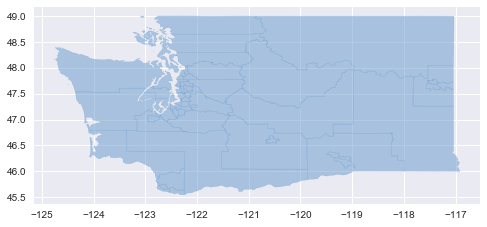

In [34]:
fig = plt.figure()
ax = fig.gca()
BLUE = '#6699cc'
for poly in all_polygons:
    ax.add_patch(PolygonPatch(poly['geometry'], fc=BLUE, ec=BLUE, alpha=0.5,zorder=2))
ax.axis('scaled')
plt.show()

In [35]:
# Write percent snap data to geographic file
    # Only have to run this once. Just load "intersection.shp" after first time (go next cell onwards)
# Reference this page: https://gis.stackexchange.com/questions/178765/intersecting-two-shapefiles-from-python-or-command-line

schema =  {'geometry': 'Polygon','properties': {'puma_code': 'int','perc_snap':'float'}}

with fiona.open('intersection.shp', 'w',driver='ESRI Shapefile', schema=schema) as output:
    for pum in fiona.open('Data/cb_2017_53_puma10_500k.shp'):
        for index, row in df.iterrows():
            if int(pum['properties']['PUMACE10']) == row.PUMA:
                #print(row.PUMA)
                prop = {'puma_code': row.PUMA, 'perc_snap': row.perc_snap}
                output.write({'geometry':mapping(shape(pum['geometry'])),'properties': prop})
                #print('mapping worked!')

In [37]:
merged_shape = fiona.open("intersection.shp")

In [38]:
df

,PUMA,receives_snap,no_snap,All,perc_snap
0,10100,12220.0,76416.0,88636.0,0.137867
1,10200,10692.0,80878.0,91570.0,0.116763
2,10300,3722.0,38747.0,42469.0,0.087640
3,10400,7629.0,36226.0,43855.0,0.173960
4,10501,9840.0,41653.0,51493.0,0.191094
5,10502,8252.0,44970.0,53222.0,0.155049
6,10503,9052.0,47382.0,56434.0,0.160400
7,10504,3579.0,36221.0,39800.0,0.089925
8,10600,4906.0,37530.0,42436.0,0.115609
9,10701,6305.0,33733.0,40038.0,0.157475


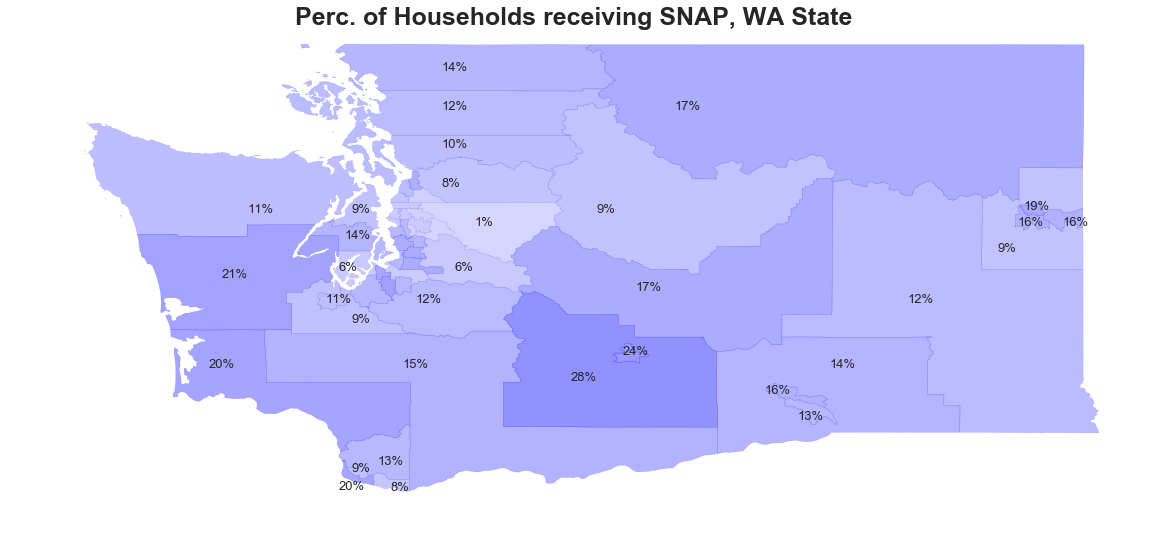

In [39]:
# Map shapefile for WA state
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
alphas = []

for _, poly in merged_shape.items():
    ax.add_patch(PolygonPatch(poly['geometry'], fc='BLUE', ec='BLUE', alpha=poly['properties']['perc_snap']+0.15))    
    alphas.append(poly['properties']['perc_snap'])
ax.axis('scaled')
ax.grid(False)
plt.figtext(.5,.84,'Perc. of Households receiving SNAP, WA State', fontsize=25, fontweight='bold',ha='center')
#plt.figtext(.5,.85,'(Darkest: '+str(int(max(alphas)*100))+ '%   Lightest: '+str(int(min(alphas)*100))+'%)', fontsize=20, ha='center')
#plt.figtext(.5,.85,'(Dark = High)', fontsize=20, ha='center')

# Label percentages 
plt.text(-123.5,47.7,'11%',fontsize=13) #11900
plt.text(-123.7,47.2,'21%',fontsize=13) #11300
plt.text(-123.8,46.5,'20%',fontsize=13) #11200
plt.text(-122.3,46.5,'15%',fontsize=13) #11000
plt.text(-122,48.8,'14%',fontsize=13) #10100
plt.text(-122,48.5,'12%',fontsize=13) #10200
plt.text(-122,48.2,'10%',fontsize=13) #11706
plt.text(-122,47.9,'8%',fontsize=13) #11705
plt.text(-121.75,47.6,'1%',fontsize=13) #11616
plt.text(-121.9,47.25,'6%',fontsize=13) #11615
plt.text(-122.2,47,'12%',fontsize=13) #11507
plt.text(-120.2,48.5,'17%',fontsize=13) #10400
plt.text(-120.8,47.7,'9%',fontsize=13) #10300
plt.text(-120.5,47.1,'17%',fontsize=13) #10800
plt.text(-120.6,46.6,'24%',fontsize=13) #10901
plt.text(-121,46.4,'28%',fontsize=13) #10902
plt.text(-117.5,47.72,'19%',fontsize=13) #10501
plt.text(-117.55,47.6,'16%',fontsize=13) #10502
plt.text(-117.2,47.6,'16%',fontsize=13) #10503
plt.text(-117.7,47.4,'9%',fontsize=13) #10504
plt.text(-118.4,47,'12%',fontsize=13) #10600
plt.text(-119.5,46.3,'16%',fontsize=13) #10701
plt.text(-119.25,46.1,'13%',fontsize=13) #10702
plt.text(-119,46.5,'14%',fontsize=13) #10703
plt.text(-122.7,46.85,'9%',fontsize=13) #11402
plt.text(-122.9,47,'11%',fontsize=13) #11401
plt.text(-122.8,45.56,'20%',fontsize=13) #11101
plt.text(-122.7,45.7,'9%',fontsize=13) #11102
plt.text(-122.4,45.55,'8%',fontsize=13) #11103
plt.text(-122.5,45.75,'13%',fontsize=13) #11104
plt.text(-122.7,47.7,'9%',fontsize=13) #11801
plt.text(-122.75,47.5,'14%',fontsize=13) #11802
plt.text(-122.8,47.25,'6%',fontsize=13) #11502

plt.axis('off')
plt.savefig('WA_hunger_location.png')
plt.show()

In [40]:
seattle_pumas = [11601, 11602, 11603, 11604, 11605, 11606, 11610, 11611]

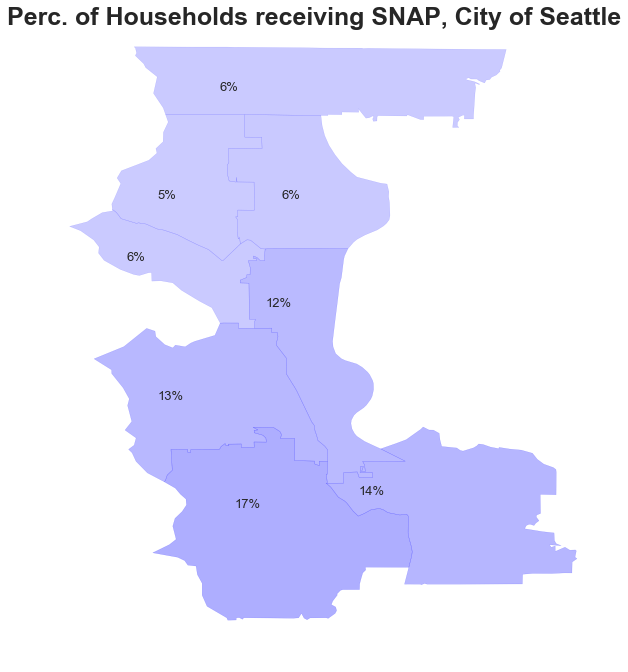

In [41]:
# Map shapefile for City of Seattle 
fig = plt.figure(figsize=(10,12))
ax = fig.gca()
alphas = []
for _, poly in merged_shape.items():
    if poly['properties']['puma_code'] in seattle_pumas:
        ax.add_patch(PolygonPatch(poly['geometry'], fc='BLUE', ec='BLUE', alpha=poly['properties']['perc_snap']+0.15,zorder=2))
        alphas.append(poly['properties']['perc_snap'])
ax.axis('scaled')
ax.grid(False)
plt.figtext(.5,.86,'Perc. of Households receiving SNAP, City of Seattle', fontsize=25, fontweight='bold',ha='center')
#plt.figtext(.5,.85,'(Darkest: '+str(int(max(alphas)*100))+ '%   Lightest: '+str(int(min(alphas)*100))+'%)', fontsize=20, ha='center')
#plt.title('Percentage of Households receiving SNAP (dark = high)')

# Label percentages
plt.text(-122.38,47.68,'5%',fontsize=13) #11601
plt.text(-122.30,47.68,'6%',fontsize=13) #11602
plt.text(-122.40,47.64,'6%',fontsize=13) #11603
plt.text(-122.31,47.61,'12%',fontsize=13) #11604
plt.text(-122.38,47.55,'13%',fontsize=13) #11605
plt.text(-122.34,47.75,'6%',fontsize=13) #11606
plt.text(-122.25,47.488,'14%',fontsize=13) #11610
plt.text(-122.33,47.48,'17%',fontsize=13) #11611

plt.axis('off')
plt.savefig('Seattle_hunger_location.png')
plt.show()

## Start Interesting Statistics
Reference data dictionary to understand labels: https://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMS_Data_Dictionary_2017.pdf

### Baseline

In [42]:
df.tail()

,PUMA,receives_snap,no_snap,All,perc_snap
52,11706,5730.0,49350.0,55080.0,0.104031
53,11801,4722.0,45660.0,50382.0,0.093724
54,11802,7900.0,46620.0,54520.0,0.144901
55,11900,5271.0,42650.0,47921.0,0.109994
56,All,343469.0,2496901.0,2840370.0,0.120924


In [43]:
df.to_csv(path_or_buf='SNAP_by_PUMA.csv')

In [44]:
df.loc[56]
# 12% of WA households receive SNAP

PUMA                     All
receives_snap         343469
no_snap           2.4969e+06
All              2.84037e+06
perc_snap           0.120924
Name: 56, dtype: object

### Household Income

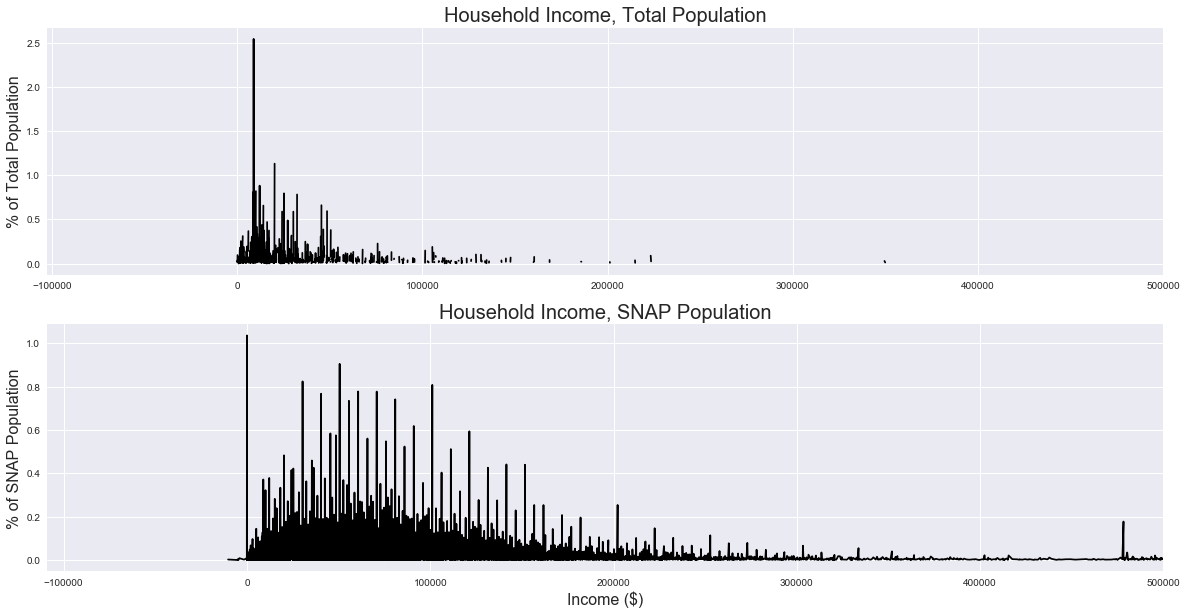

In [47]:
df = pd.crosstab(pumas_hh_merge.HINCP,pumas_hh_merge.FS,pumas_hh_merge.WGTP,aggfunc=sum,margins=True)
column_names = df.columns.values
column_names[0] = 'receives_snap'
column_names[1] = 'no_snap'
df.columns = column_names
df.reset_index(inplace=True)
df['% of SNAP recipients'] = df.receives_snap/(df.receives_snap.values[-1])*100
df['% of total population'] = df.All/(df.All.values[-1])*100
df = df.drop(['receives_snap','no_snap','All'],axis=1)
df = df[:-1]


# Make plots
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(df['HINCP'],df['% of SNAP recipients'],'k')
plt.ylabel('% of Total Population',fontsize=16)
plt.xlim((None,500000))
plt.title('Household Income, Total Population',fontsize=20)
plt.subplot(2,1,2)
plt.plot(df['HINCP'],df['% of total population'],'k')
plt.ylabel('% of SNAP Population',fontsize=16)
plt.xlabel('Income ($)',fontsize=16)
plt.xlim((None,500000))
plt.title('Household Income, SNAP Population',fontsize=20)
plt.savefig('Household_Income.png')
plt.show()

### Age of Household Head

In [48]:
# Histograms, frequency of each age group
df = pd.crosstab(pumas_hh_merge.AGEP,pumas_hh_merge.FS,pumas_hh_merge.WGTP,aggfunc=sum,margins=True)
column_names = df.columns.values
column_names[0] = 'receives_snap'
column_names[1] = 'no_snap'
df.columns = column_names
df.reset_index(inplace=True)
df['% of SNAP recipients'] = df.receives_snap/(df.receives_snap.values[-1])*100
df['% of total population'] = df.All/(df.All.values[-1])*100
df = df[:-1]
df['AGEP'] = df['AGEP'].astype('int')
print(df.head())

   AGEP  receives_snap  no_snap      All  % of SNAP recipients  \
0    16            NaN    187.0    187.0                   NaN   
1    17           70.0      NaN     70.0              0.020380   
2    18          155.0   1025.0   1180.0              0.045128   
3    19         1416.0   6357.0   7773.0              0.412264   
4    20         1394.0  12052.0  13446.0              0.405859   

   % of total population  
0               0.006584  
1               0.002464  
2               0.041544  
3               0.273662  
4               0.473389  


In [49]:
df.fillna(0,inplace=True)

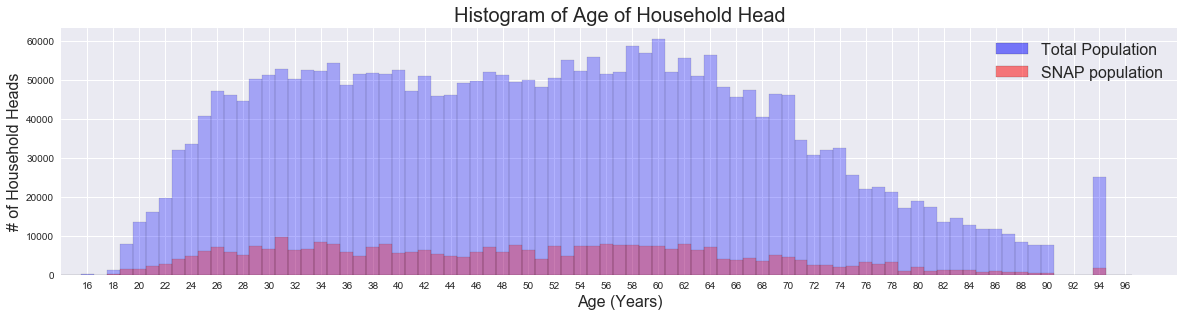

In [50]:
# Make plots
    # Source for xticks: https://stackoverflow.com/questions/27083051/matplotlib-xticks-not-lining-up-with-histogram
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.hist(df.AGEP,weights=df.All,bins=np.arange(0,max(df.AGEP)+4,1)-0.5,color='blue',edgecolor='black',alpha=0.3) # 1 year
plt.xticks(np.arange(min(df.AGEP), max(df.AGEP)+4,2))
plt.xlim([14,100])
plt.ylabel('# of Household Heads',fontsize=16)
plt.title('Histogram of Age of Household Head, Total Population',fontsize=20)
plt.hist(df.AGEP,weights=df.receives_snap,bins=np.arange(0,max(df.AGEP)+4,1)-0.5,color='red',edgecolor='black',alpha=0.3) # 1 year
plt.xticks(np.arange(min(df.AGEP), max(df.AGEP)+4,2))
plt.ylabel('# of Household Heads',fontsize=16)
plt.xlabel('Age (Years)',fontsize=16)
plt.xlim([14,100])
plt.title('Histogram of Age of Household Head',fontsize=20)

#create legend
handles = [Rectangle((0,0),1,1,color=c,ec="k",alpha=0.5) for c in ['blue','red']]
labels= ["Total Population","SNAP population"]
plt.legend(handles, labels,fontsize=16)

plt.savefig('outputs/Hist_Household_Head_Age.png')
plt.show()

### Parameterized tables

**For categorical variables, SNAP v. non-SNAP** 

In [51]:
def build_table_cat_sns(pumas_table,var,weight):
    df = pd.crosstab(pumas_table[var],pumas_table.FS,pumas_table[weight],aggfunc=sum,margins=True)
    column_names = df.columns.values
    column_names[0] = 'receives_snap'
    column_names[1] = 'no_snap'
    df.columns = column_names
    df.reset_index(inplace=True)
    df['% Receiving SNAP'] = df.receives_snap/df.All*100
    df['% Not Receiving SNAP'] = df.no_snap/df.All*100
    df['Total Population'] = df.All/df.All*100
    df = df.drop(['receives_snap','no_snap','All'],axis=1)
    for index, row in df.iterrows():
        df.at[index, '% Receiving SNAP'] = "%.2f" %row['% Receiving SNAP']
        df.at[index, '% Not Receiving SNAP'] = "%.2f" %row['% Not Receiving SNAP']
        df.at[index, 'Total Population'] = "%.2f" %row['Total Population']
    print(df)
    return df 

**For categorical variables, SNAP v. Total Population** 

In [52]:
def build_table_cat_stot(pumas_table,var,weight):
    df = pd.crosstab(pumas_table[var],pumas_table.FS,pumas_table.WGTP,aggfunc=sum,margins=True)
    column_names = df.columns.values
    column_names[0] = 'receives_snap'
    column_names[1] = 'no_snap'
    df.columns = column_names
    df.reset_index(inplace=True)
    #print(df)
    df['% of SNAP recipients'] = df.receives_snap/(df.receives_snap.values[-1])*100
    df['% of total population'] = df.All/(df.All.values[-1])*100
    df = df.drop(['receives_snap','no_snap','All'],axis=1)
    for index, row in df.iterrows():
        df.at[index, '% of SNAP recipients'] = "%.2f" %row['% of SNAP recipients']
        df.at[index, '% of total population'] = "%.2f" %row['% of total population']
    print(df)
    return(df)

In general, SNAP v. Total Population is more intuitive than SNAP v. non-SNAP; thus it is used more often below (e.g. for generating plots and graphs) 

### Language spoken at home

In [55]:
df_hhl_sns = build_table_cat_sns(pumas_hh_merge,'HHL','WGTP')

   HHL  % Receiving SNAP  % Not Receiving SNAP  Total Population
0    1             11.09                 88.91             100.0
1    2             20.81                 79.19             100.0
2    3             11.31                 88.69             100.0
3    4             11.47                 88.53             100.0
4    5             30.50                 69.50             100.0
5  All             12.09                 87.91             100.0


In [56]:
df_hhl_stot = build_table_cat_stot(pumas_hh_merge,'HHL','WGTP')

   HHL  % of SNAP recipients  % of total population
0    1                 73.16                  79.76
1    2                 13.22                   7.68
2    3                  4.52                   4.83
3    4                  6.27                   6.60
4    5                  2.83                   1.12
5  All                100.00                 100.00


### Number of persons in HH

In [57]:
df_np_sns = build_table_cat_sns(pumas_hh_merge,'NP','WGTP')

     NP  % Receiving SNAP  % Not Receiving SNAP  Total Population
0     1             11.65                 88.35             100.0
1     2              7.67                 92.33             100.0
2     3             14.36                 85.64             100.0
3     4             12.96                 87.04             100.0
4     5             19.53                 80.47             100.0
5     6             33.31                 66.69             100.0
6     7             29.80                 70.20             100.0
7     8             41.16                 58.84             100.0
8     9             50.71                 49.29             100.0
9    10             32.01                 67.99             100.0
10   11             62.65                 37.35             100.0
11   12             19.97                 80.03             100.0
12   13             47.75                 52.25             100.0
13   14            100.00                   NaN             100.0
14  All   

In [58]:
df_np_stot = build_table_cat_stot(pumas_hh_merge,'NP','WGTP')

     NP  % of SNAP recipients  % of total population
0     1                 25.42                  26.40
1     2                 22.82                  35.99
2     3                 17.89                  15.07
3     4                 14.05                  13.11
4     5                  8.96                   5.55
5     6                  6.48                   2.35
6     7                  2.32                   0.94
7     8                  1.18                   0.35
8     9                  0.45                   0.11
9    10                  0.20                   0.08
10   11                  0.15                   0.03
11   12                  0.03                   0.02
12   13                  0.03                   0.01
13   14                  0.01                   0.00
14  All                100.00                 100.00


In [59]:
df_np_stot.iloc[2]=['3-4',df_np_stot.iloc[2,1]+df_np_stot.iloc[3,1],df_np_stot.iloc[2,2]+df_np_stot.iloc[3,2]]

In [60]:
df_np_stot.fillna(0,inplace=True)

In [61]:
df_np_stot.iloc[3]=['5-8',df_np_stot.iloc[4,1]+df_np_stot.iloc[5,1]+df_np_stot.iloc[6,1]+df_np_stot.iloc[7,1],df_np_stot.iloc[4,2]+df_np_stot.iloc[5,2]+df_np_stot.iloc[6,2]+df_np_stot.iloc[7,2]]

In [62]:
df_np_stot.iloc[4]=['9-14',df_np_stot.iloc[8,1]+df_np_stot.iloc[9,1]+df_np_stot.iloc[10,1]+df_np_stot.iloc[11,1]+df_np_stot.iloc[12,1]+df_np_stot.iloc[13,1],df_np_stot.iloc[8,2]+df_np_stot.iloc[9,2]+df_np_stot.iloc[10,2]+df_np_stot.iloc[11,2]+df_np_stot.iloc[12,2]+df_np_stot.iloc[13,2]]

In [63]:
df_np_stot.drop([5,6,7,8,9,10,11,12,13,14],inplace=True)

In [64]:
df_np_stot

,NP,% of SNAP recipients,% of total population
0,1,25.42,26.40
1,2,22.82,35.99
2,3-4,31.94,28.18
3,5-8,18.94,9.19
4,9-14,0.87,0.25


### Household Type

In [65]:
df_hht_sns = build_table_cat_sns(pumas_hh_merge,'HHT','WGTP')

   HHT  % Receiving SNAP  % Not Receiving SNAP  Total Population
0    1              6.22                 93.78             100.0
1    2             24.04                 75.96             100.0
2    3             35.43                 64.57             100.0
3    4             10.92                 89.08             100.0
4    5             13.13                 86.87             100.0
5    6             12.29                 87.71             100.0
6    7             15.37                 84.63             100.0
7  All             12.09                 87.91             100.0


In [66]:
df_hht_stot = build_table_cat_stot(pumas_hh_merge,'HHT','WGTP')

   HHT  % of SNAP recipients  % of total population
0    1                 25.73                  50.03
1    2                  9.55                   4.81
2    3                 28.86                   9.85
3    4                 11.19                  12.39
4    5                  5.33                   4.90
5    6                 14.24                  14.01
6    7                  5.10                   4.02
7  All                100.00                 100.00


### Family Type and Employment Status

In [67]:
df_fes_sns = build_table_cat_sns(pumas_hh_merge,'FES','WGTP')

   FES  % Receiving SNAP  % Not Receiving SNAP  Total Population
0    1              4.44                 95.56             100.0
1    2              9.65                 90.35             100.0
2    3              8.34                 91.66             100.0
3    4              6.37                 93.63             100.0
4    5             20.21                 79.79             100.0
5    6             37.49                 62.51             100.0
6    7             31.56                 68.44             100.0
7    8             45.73                 54.27             100.0
8  All             12.08                 87.92             100.0


In [68]:
df_fes_stot = build_table_cat_stot(pumas_hh_merge,'FES','WGTP')

   FES  % of SNAP recipients  % of total population
0    1                 14.59                  39.72
1    2                 13.88                  17.38
2    3                  4.01                   5.81
3    4                  7.48                  14.20
4    5                  9.76                   5.84
5    6                  5.17                   1.67
6    7                 29.20                  11.18
7    8                 15.90                   4.20
8  All                100.00                 100.00


In [69]:
df_fes_stot.iloc[0]=['Married, 1+ employed',df_fes_stot.iloc[0,1]+df_fes_stot.iloc[1,1]+df_fes_stot.iloc[2,1],df_fes_stot.iloc[0,2]+df_fes_stot.iloc[1,2]+df_fes_stot.iloc[2,2]]
df_fes_stot.iloc[3,0]='Married, both unemployed'
df_fes_stot.iloc[4]=['Single, employed',df_fes_stot.iloc[4,1]+df_fes_stot.iloc[6,1],df_fes_stot.iloc[4,2]+df_fes_stot.iloc[6,2]]
df_fes_stot.iloc[5]=['Single, unemployed',df_fes_stot.iloc[5,1]+df_fes_stot.iloc[7,1],df_fes_stot.iloc[5,2]+df_fes_stot.iloc[7,2]]
df_fes_stot.drop([1,2,6,7,8],inplace=True)
df_fes_stot

,FES,% of SNAP recipients,% of total population
0,"Married, 1+ employed",32.48,62.91
3,"Married, both unemployed",7.48,14.20
4,"Single, employed",38.96,17.02
5,"Single, unemployed",21.07,5.87


### Presence and Age of Children

In [70]:
df_hupac_sns = build_table_cat_sns(pumas_hh_merge,'HUPAC','WGTP')

  HUPAC  % Receiving SNAP  % Not Receiving SNAP  Total Population
0     1             17.56                 82.44             100.0
1     2             14.01                 85.99             100.0
2     3             26.28                 73.72             100.0
3     4              9.70                 90.30             100.0
4   All             12.09                 87.91             100.0


In [71]:
df_hupac_stot = build_table_cat_stot(pumas_hh_merge,'HUPAC','WGTP')

  HUPAC  % of SNAP recipients  % of total population
0     1                 10.95                   7.54
1     2                 18.75                  16.19
2     3                 14.42                   6.64
3     4                 55.87                  69.63
4   All                100.00                 100.00


In [72]:
df_hupac_stot.iloc[3,0] = 'No own children present'

In [73]:
df_hupac_stot.iloc[4] = ['Own children present',df_hupac_stot.iloc[0,1]+df_hupac_stot.iloc[1,1]+df_hupac_stot.iloc[2,1],df_hupac_stot.iloc[0,2]+df_hupac_stot.iloc[1,2]+df_hupac_stot.iloc[2,2]]

In [74]:
df_hupac_stot.drop([0,1,2],inplace=True)

In [75]:
df_hupac_stot.reset_index(drop=True,inplace=True)

In [76]:
df_hupac_stot

,HUPAC,% of SNAP recipients,% of total population
0,No own children present,55.87,69.63
1,Own children present,44.12,30.37


### Household Head's Ability to Speak English

In [77]:
df_eng_sns = build_table_cat_sns(pumas_hh_merge,'ENG','WGTP')

   ENG  % Receiving SNAP  % Not Receiving SNAP  Total Population
0    1             11.85                 88.15             100.0
1    2             16.89                 83.11             100.0
2    3             32.60                 67.40             100.0
3    4             37.56                 62.44             100.0
4  All             16.83                 83.17             100.0


In [78]:
df_eng_stot = build_table_cat_stot(pumas_hh_merge,'ENG','WGTP')

   ENG  % of SNAP recipients  % of total population
0    1                 42.93                  60.96
1    2                 21.32                  21.24
2    3                 26.31                  13.58
3    4                  9.44                   4.23
4  All                100.00                 100.00


### Household Head's Military Service Background

In [79]:
df_mil_sns = build_table_cat_sns(pumas_hh_merge,'MIL','WGTP')

   MIL  % Receiving SNAP  % Not Receiving SNAP  Total Population
0    1              2.44                 97.56             100.0
1    2              8.66                 91.34             100.0
2    3              9.56                 90.44             100.0
3    4             12.70                 87.30             100.0
4  All             12.09                 87.91             100.0


In [80]:
df_mil_stot = build_table_cat_stot(pumas_hh_merge,'MIL','WGTP')

   MIL  % of SNAP recipients  % of total population
0    1                  0.15                   0.75
1    2                  8.58                  11.98
2    3                  1.20                   1.52
3    4                 90.06                  85.74
4  All                100.00                 100.00


### Household Head's Sex

In [84]:
df_sex_sns = build_table_cat_sns(pumas_hh_merge,'SEX','WGTP')

   SEX  % Receiving SNAP  % Not Receiving SNAP  Total Population
0    1              9.42                 90.58             100.0
1    2             14.98                 85.02             100.0
2  All             12.09                 87.91             100.0


In [85]:
df_sex_stot = build_table_cat_stot(pumas_hh_merge,'SEX','WGTP')

   SEX  % of SNAP recipients  % of total population
0    1                 40.44                  51.93
1    2                 59.56                  48.07
2  All                100.00                 100.00


In [86]:
df_sex_stot.drop(2,inplace=True)

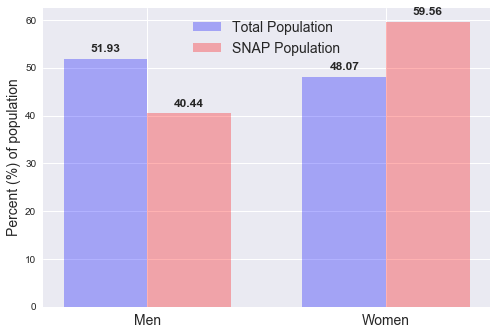

In [87]:
ind = np.arange(len(df_sex_stot))
width = 0.35 
fig, ax = plt.subplots()
rects1 = ax.bar(ind, df_sex_stot['% of total population'], width, color='b',alpha=0.3)
rects2 = ax.bar(ind + width, df_sex_stot['% of SNAP recipients'], width, color='r',alpha=0.3)
ax.set_ylabel('Percent (%) of population',fontsize=14)
#ax.set_title('Scores by group and gender')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Men', 'Women'),fontsize=14)
ax.legend((rects1[0], rects2[0]), ('Total Population', 'SNAP Population'),fontsize=14)
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height+1.05,
                '%s' %str(height),
                ha='center', va='bottom',fontsize=12,fontweight='bold')
autolabel(rects1)
autolabel(rects2)
plt.grid('on')
plt.savefig('outputs/Bar_Household_Head_Sex.png')
plt.show()

### Household Head's Health Insurance Coverage

In [88]:
df_hicov_sns = build_table_cat_sns(pumas_hh_merge,'HICOV','WGTP')

  HICOV  % Receiving SNAP  % Not Receiving SNAP  Total Population
0     1             11.68                 88.32             100.0
1     2             18.87                 81.13             100.0
2   All             12.09                 87.91             100.0


In [89]:
df_hicov_stot = build_table_cat_stot(pumas_hh_merge,'HICOV','WGTP')

  HICOV  % of SNAP recipients  % of total population
0     1                 91.12                  94.31
1     2                  8.88                   5.69
2   All                100.00                 100.00


### Household Head's Nativity

In [90]:
df_nat_sns = build_table_cat_sns(pumas_hh_merge,'NATIVITY','WGTP')

  NATIVITY  % Receiving SNAP  % Not Receiving SNAP  Total Population
0        1             11.47                 88.53             100.0
1        2             15.45                 84.55             100.0
2      All             12.09                 87.91             100.0


In [91]:
df_nat_stot = build_table_cat_stot(pumas_hh_merge,'NATIVITY','WGTP')

  NATIVITY  % of SNAP recipients  % of total population
0        1                 79.95                   84.3
1        2                 20.05                   15.7
2      All                100.00                  100.0


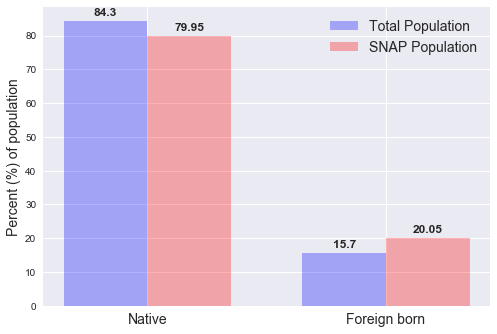

In [92]:
df_nat_stot.drop(2,inplace=True)
ind = np.arange(len(df_nat_stot))
width = 0.35 
fig, ax = plt.subplots()
rects1 = ax.bar(ind, df_nat_stot['% of total population'], width, color='b',alpha=0.3)
rects2 = ax.bar(ind + width, df_nat_stot['% of SNAP recipients'], width, color='r',alpha=0.3)
ax.set_ylabel('Percent (%) of population',fontsize=14)
#ax.set_title('Scores by group and gender')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Native', 'Foreign born'),fontsize=14)
ax.legend((rects1[0], rects2[0]), ('Total Population', 'SNAP Population'),fontsize=14)
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height+1.05,
                '%s' %str(height),
                ha='center', va='bottom',fontsize=12,fontweight='bold')
autolabel(rects1)
autolabel(rects2)
plt.grid('on')
plt.savefig('outputs/Bar_Household_Head_Nativity.png')
plt.show()

### Household Head's Race

In [93]:
df_race_sns = build_table_cat_sns(pumas_hh_merge,'RAC1P','WGTP')

  RAC1P  % Receiving SNAP  % Not Receiving SNAP  Total Population
0     1             10.71                 89.29             100.0
1     2             28.41                 71.59             100.0
2     3             28.89                 71.11             100.0
3     4             14.12                 85.88             100.0
4     5             41.91                 58.09             100.0
5     6              8.85                 91.15             100.0
6     7             23.90                 76.10             100.0
7     8             21.41                 78.59             100.0
8     9             18.93                 81.07             100.0
9   All             12.09                 87.91             100.0


In [94]:
df_race_stot = build_table_cat_stot(pumas_hh_merge,'RAC1P','WGTP')

  RAC1P  % of SNAP recipients  % of total population
0     1                 71.28                  80.45
1     2                  8.34                   3.55
2     3                  2.07                   0.87
3     4                  0.05                   0.05
4     5                  0.32                   0.09
5     6                  5.63                   7.69
6     7                  0.89                   0.45
7     8                  5.79                   3.27
8     9                  5.62                   3.59
9   All                100.00                 100.00


### Household Head's Means of Transportation to Work

In [95]:
df_jwtr_sns = build_table_cat_sns(pumas_hh_merge,'JWTR','WGTP') 

   JWTR  % Receiving SNAP  % Not Receiving SNAP  Total Population
0     1              8.86                 91.14             100.0
1     2             10.96                 89.04             100.0
2     3             20.32                 79.68             100.0
3     4             10.69                 89.31             100.0
4     5             11.72                 88.28             100.0
5     6              7.58                 92.42             100.0
6     7             13.35                 86.65             100.0
7     8              2.63                 97.37             100.0
8     9              5.60                 94.40             100.0
9    10              9.88                 90.12             100.0
10   11              5.74                 94.26             100.0
11   12              5.91                 94.09             100.0
12  All              8.76                 91.24             100.0


In [96]:
df_jwtr_stot = build_table_cat_stot(pumas_hh_merge,'JWTR','WGTP') 

   JWTR  % of SNAP recipients  % of total population
0     1                 82.09                  81.21
1     2                  7.20                   5.76
2     3                  0.18                   0.08
3     4                  0.43                   0.35
4     5                  0.39                   0.29
5     6                  0.29                   0.33
6     7                  0.20                   0.13
7     8                  0.08                   0.27
8     9                  0.42                   0.65
9    10                  3.72                   3.30
10   11                  4.55                   6.94
11   12                  0.47                   0.69
12  All                100.00                 100.00


In [97]:
df_jwtr_stot.iloc[0] = ['Car, Truck, Van, or Motorcycle',df_jwtr_stot.iloc[0,1]+df_jwtr_stot.iloc[7,1],df_jwtr_stot.iloc[0,2]+df_jwtr_stot.iloc[7,2]]

In [98]:
df_jwtr_stot.iloc[1] = ['Bus, Trolley/Streetcar, Subway, or Ferry',df_jwtr_stot.iloc[1,1]+df_jwtr_stot.iloc[2,1]+df_jwtr_stot.iloc[3,1]+df_jwtr_stot.iloc[4,1]+df_jwtr_stot.iloc[5,1],df_jwtr_stot.iloc[1,2]+df_jwtr_stot.iloc[2,2]+df_jwtr_stot.iloc[3,2]+df_jwtr_stot.iloc[4,2]+df_jwtr_stot.iloc[5,2]]

In [99]:
df_jwtr_stot.iloc[6,0] = 'Taxicab'

In [100]:
df_jwtr_stot.iloc[8,0] = 'Bicycle'

In [101]:
df_jwtr_stot.iloc[9,0] = 'Walked'

In [102]:
df_jwtr_stot.iloc[10,0] = 'Worked at home'

In [103]:
df_jwtr_stot.iloc[11,0] = 'Other'

In [104]:
df_jwtr_stot = df_jwtr_stot.drop([2,3,4,5,7,12])

In [105]:
df_jwtr_stot

,JWTR,% of SNAP recipients,% of total population
0,"Car, Truck, Van, or Motorcycle",82.17,81.48
1,"Bus, Trolley/Streetcar, Subway, or Ferry",8.49,6.81
6,Taxicab,0.20,0.13
8,Bicycle,0.42,0.65
9,Walked,3.72,3.30
10,Worked at home,4.55,6.94
11,Other,0.47,0.69


### Household Language Detailed

In [106]:
df_hhlanp_stot = build_table_cat_stot(pumas_hh_merge,'HHLANP','WGTP')

    HHLANP  % of SNAP recipients  % of total population
0     1000                   NaN                   0.01
1     1025                   NaN                   0.01
2     1055                  0.02                   0.05
3     1110                  0.30                   0.62
4     1120                   NaN                   0.01
5     1130                   NaN                   0.00
6     1132                  0.09                   0.11
7     1134                   NaN                   0.02
8     1140                   NaN                   0.06
9     1141                  0.02                   0.04
10    1142                  0.04                   0.09
11    1155                  0.04                   0.10
12    1170                  0.53                   0.60
13    1200                 13.22                   7.68
14    1210                  0.15                   0.14
15    1220                  0.07                   0.15
16    1231                  0.09                

In [107]:
df_hhlanp_stot = df_hhlanp_stot[:-1]
df_hhlanp_stot.sort_values(ascending=False,by='% of SNAP recipients',axis=0,inplace=True)
print(df_hhlanp_stot.head(10))
df_hhlanp_stot.sort_values(ascending=False,by='% of total population',axis=0,inplace=True)
print(df_hhlanp_stot.head(10))

    HHLANP  % of SNAP recipients  % of total population
108   9500                 73.16                  79.76
13    1200                 13.22                   7.68
19    1250                  1.66                   0.82
55    1960                  1.51                   0.85
89    4840                  0.85                   0.13
73    2920                  0.79                   0.83
56    1970                  0.77                   1.09
68    2575                  0.64                   0.76
54    1900                  0.55                   0.24
12    1170                  0.53                   0.60
    HHLANP  % of SNAP recipients  % of total population
108   9500                 73.16                  79.76
13    1200                 13.22                   7.68
56    1970                  0.77                   1.09
55    1960                  1.51                   0.85
73    2920                  0.79                   0.83
19    1250                  1.66                

SNAP recipients top 10 HHLANPs: 
1. 9500 = English-only household
2. 1200 = Spanish
3. 1250 = Russian
4. 1960 = Vietnamese
5. 4840 = Somali
6. 2920 = Tagalog
7. 1970 = Chinese
8. 2575 = Korean
9. 1900 = Khmer
10. 1170 = French

Total Population Top 10 HHLANPs: 
1. 9500 = English-only household
2. 1200 = Spanish
3. 1970 = Chinese
4. 1960 = Vietnamese
5. 2920 = Tagalog
6. 1250 = Russian
7. 2575 = Korean
8. 1110 = German
9. 1170 = French
10. 1350 = Hindi

### Household Head's Occupation

In [108]:
df_occp_sns = build_table_cat_sns(pumas_hh_merge,'OCCP','WGTP')

     OCCP  % Receiving SNAP  % Not Receiving SNAP  Total Population
0      10              1.94                 98.06             100.0
1      20              2.00                 98.00             100.0
2      40             11.38                 88.62             100.0
3      50              4.28                 95.72             100.0
4      60               NaN                100.00             100.0
5     100              1.67                 98.33             100.0
6     110              0.89                 99.11             100.0
7     120              1.66                 98.34             100.0
8     135               NaN                100.00             100.0
9     136               NaN                100.00             100.0
10    137               NaN                100.00             100.0
11    140              1.79                 98.21             100.0
12    150               NaN                100.00             100.0
13    160              1.38                 98.6

In [109]:
df_occp_stot = build_table_cat_stot(pumas_hh_merge,'OCCP','WGTP')
df_occp_stot = df_occp_stot[:-1]
df_occp_stot.sort_values(ascending=False,by='% of SNAP recipients',axis=0,inplace=True)
print(df_occp_stot.head(10))
df_occp_stot.sort_values(ascending=False,by='% of total population',axis=0,inplace=True)
print(df_occp_stot.head(10))

     OCCP  % of SNAP recipients  % of total population
0      10                  0.16                   0.88
1      20                  0.17                   0.88
2      40                  0.05                   0.04
3      50                  0.33                   0.80
4      60                   NaN                   0.04
5     100                  0.03                   0.18
6     110                  0.05                   0.64
7     120                  0.11                   0.72
8     135                   NaN                   0.01
9     136                   NaN                   0.34
10    137                   NaN                   0.05
11    140                  0.04                   0.24
12    150                   NaN                   0.20
13    160                  0.02                   0.18
14    205                  0.17                   0.36
15    220                  0.17                   0.79
16    230                  0.15                   0.55
17    300 

SNAP recipients top 10 OCCPs: 
1. 4720 = Cashiers
2. 6050 = Miscellaneous Agricultural Workers, Including Animal Breeders
3. 4610 = Personal Care Aides
4. 9130 = Driver/Sales Workers And Truck Drivers
5. 5240 = Customer Service Representatives
6. 4020 = Cooks
7. 4220 = Janitors And Building Cleaners
8. 4760 = Retail Salespersons
9. 4230 = Maids And Housekeeping Cleaners
10. 430 = Miscellaneous Managers, Including Funeral Service Managers And Postmasters And Mail Superintendents

Total Population Top 10 OCCPs: 
1. 430 = Miscellaneous Managers, Including Funeral Service Managers And Postmasters And Mail Superintendents
2. 1020 = Software Developers, Applications And Systems Software
3. 2310 = Elementary And Middle School Teachers
4. 9130 = Driver/Sales Workers And Truck Drivers
5. 3255 = Registered Nurses
6. 4700 = First-Line Supervisors Of Retail Sales Workers
7. 5700 = Secretaries And Administrative Assistants
8. 5240 = Customer Service Representatives
9. 4220 = Janitors And Building Cleaners
10. 4760 = Retail Salespersons